In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

# Uncomment the next two lines if running for the book
import warnings
warnings.filterwarnings("ignore")

import jax
import jax.numpy as jnp
import jax.random as jrandom
import gpjax as gpx
import optax

jax.config.update("jax_enable_x64", True)
key = jrandom.PRNGKey(0)

# Example – Surrogate for stochastic heat equation with principal component analysis

In the previous example, we built a surrogate for the solution to the stochastic (steady-state) heat equation *at a single point in space*.
In this notebook, we will build a surrogate for *the entire temperature field*.

We will reuse the same probability measure on conductivity $c$, i.e., 

$$
c(x; \xi) = c_0(x) \exp\Big\{ g(x; \xi) \Big\}
$$ 

where $g$ is a Gaussian process.
As before, we implement it with the Karhunen-Loève expansion:

<!-- This allowed us to efficiently propagate uncertainty **from a random field** (the conductivity field) **to a random variable** (the temperature at the center of a rod).
In this example, instead of only building a surrogate for the solution at a single point, we will do so for the solution at **all points in space**.
This allows us to efficiently propagate uncertainty **from a random field** (the conductivity field) to **another random field** (the temperature field). -->
<!-- To do this, we put a Gaussian process prior on the conductivity field, took its Karhunen-Loève expansion, and trained  -->

In [2]:
class KarhunenLoeveExpansion(object):
    
    """
    A class representing the Karhunen Loeve Expansion of a Gaussian random field.
    It uses the Nystrom approximation to do it.
    
    Arguments:
        k      -     The covariance function.
        Xq     -     Quadrature points for the Nystrom approximation.
        wq     -     Quadrature weights for the Nystrom approximation.
        alpha  -     The percentage of the energy of the field that you want to keep.
        X      -     Observed inputs (optional).
        Y      -     Observed field values (optional).
    """
    
    def __init__(self, k, Xq=None, wq=None, nq=100, alpha=0.9, X=None, y=None, *, input_dim):

        self.k = k
        if input_dim is None:
            self.input_dim = 1
        else:
            self.input_dim = input_dim

        # Generate quadrature points
        if Xq is None:
            if input_dim is None:
                self.input_dim = 1
            if self.input_dim == 1:
                Xq = jnp.linspace(0, 1, nq)[:, None]
                wq = jnp.ones((nq, )) / nq
            elif self.input_dim == 2:
                nq = int(jnp.sqrt(nq))
                x = jnp.linspace(0, 1, nq)
                X1, X2 = jnp.meshgrid(x, x)
                Xq = jnp.hstack([X1.flatten()[:, None], X2.flatten()[:, None]])
                wq = jnp.ones((nq ** 2, )) / nq ** 2
            else:
                raise NotImplementedError('For more than 2D, please supply quadrature points and weights.')
        else:
            self.input_dim = Xq.shape[1]
        self.Xq = Xq
        self.wq = wq
        self.k = k
        self.alpha = alpha

        # Evaluate the covariance function at the quadrature points
        # If we have some observed data, we need to use the posterior covariance
        if X is not None:
            self.D = gpx.Dataset(X, y[:, None])
            prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=k)
            likelihood = gpx.likelihoods.Gaussian(num_datapoints=X.shape[0])
            posterior = prior * likelihood
            posterior.likelihood.obs_stddev = gpx.parameters.Static(1e-6)
            self.posterior = posterior
            Kq = posterior.predict(Xq, train_data=self.D).covariance()
        else:
            self.D = None
            self.prior = gpx.gps.Prior(mean_function=gpx.mean_functions.Zero(), kernel=k)
            Kq = self.prior.predict(Xq).covariance()
        
        # Get the eigenvalues/eigenvectors of the discretized covariance function
        B = jnp.einsum('ij,j->ij', Kq, wq)
        lam, v = jax.scipy.linalg.eigh(B, overwrite_a=True)
        lam = lam[::-1]
        lam = lam.at[lam <= 0.].set(0.)

        # Keep only the eigenvalues that explain alpha% of the energy
        energy = jnp.cumsum(lam) / jnp.sum(lam)
        i_end = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        lam = lam[:i_end]
        v = v[:, ::-1]
        v = v[:, :i_end]
        
        self.lam = lam
        self.sqrt_lam = jnp.sqrt(lam)
        self.v = v
        self.energy = energy
        self.num_xi = i_end
        
    def eval_phi(self, x):
        """
        Evaluate the eigenfunctions at x.
        """
        if self.D is not None:
            nq = self.Xq.shape[0]
            Xf = jnp.vstack([self.Xq, x])
            latent_dist = self.posterior.predict(Xf, train_data=self.D)
            m = latent_dist.mean()
            C = latent_dist.covariance()
            Kc = C[:nq, nq:].T
            self.tmp_mu = m[nq:]
        else:
            Kc = self.prior.kernel.cross_covariance(x, self.Xq)
            self.tmp_mu = 0.
        phi = jnp.einsum("i,ji,j,rj->ri", 1. / self.lam, self.v, self.wq**0.5, Kc)
        return phi
    
    def __call__(self, x, xi):
        """
        Evaluate the expansion at x and xi.
        """
        phi = self.eval_phi(x)
        return self.tmp_mu + jnp.dot(phi, xi * self.sqrt_lam)

In [3]:
k = gpx.kernels.RBF(lengthscale=0.1, variance=0.5)
kle = KarhunenLoeveExpansion(k, nq=1000, alpha=0.95, input_dim=1)

def c(x, xi):
    """Compute the random thermal conductivity field for a given xi."""
    return jnp.exp(kle(x, xi))

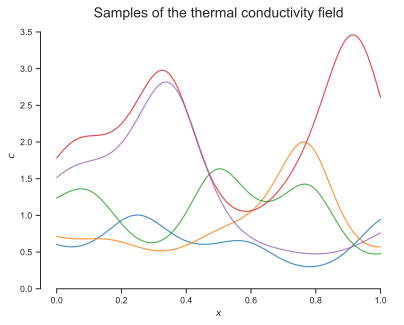

In [4]:
x = jnp.linspace(0, 1, 300)[:, None]
fig, ax = plt.subplots()
ax.set_title("Samples of the thermal conductivity field", fontsize=14)
for i in range(5):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, shape=(kle.num_xi,))
    f = c(x, xi)
    ax.plot(x, f, alpha=0.8)
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$c$")
sns.despine(trim=True);

## Reduce dimensionality of the output with PCA

The goal is to propagate uncertainty from **one stochastic function** (the conductivity field) to **another stochastic function** (the temperature field).
This requires approximating the infinite-dimensional fields with something finite-dimensional.

We have already represented the input field with a finite number of Karhunen-Loève expansion coefficients (as done in the previous example).
In a similar vein, we will represent the output temperature field with a finite number of **principal component analysis (PCA) coefficients**.

Let's do it.
First we create a solver for the heat equation:

In [5]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    g           -    The random field the describes the conductivity.
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, c=c, nx=100, value_left=1., value_right=0.):
        self.c = c
        self.nx = nx
        self.dx = 1. / nx
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        self.phi.constrain(value_left, self.mesh.facesLeft)
        self.phi.constrain(value_right, self.mesh.facesRight)
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, xi):
        """
        Evaluates the code at a specific xi.
        """
        x = self.mesh.faceCenters.value.flatten()
        c_val = self.c(x[:, None], xi)
        self.C.setValue(c_val)
        self.eq.solve(var=self.phi)
        return x, self.phi.faceValue()

In [6]:
solver = SteadyStateHeat1DSolver(nx=500)

Next, create some training (and testing) data:

In [7]:
xis = []
us = []
for i in range(100):
    key, key_xi = jrandom.split(key)
    xi = jrandom.normal(key_xi, shape=(kle.num_xi,))
    x, y = solver(xi)
    xis.append(xi)
    us.append(y)
xis = jnp.stack(xis, axis=0)
us = jnp.stack(us, axis=0)

from sklearn.model_selection import train_test_split
key, key_split = jrandom.split(key)
xi_train, xi_test, u_train, u_test = train_test_split(xis, us, test_size=0.1, random_state=int(jrandom.randint(key_split, shape=(), minval=0, maxval=1e6)))

And finally, do PCA on the training data:

In [8]:
class PrincipalComponentAnalysis(object):
    def __init__(self, X, alpha=0.9):
        self.x_bar = jnp.mean(X, axis=0)
        B = X - self.x_bar
        U, s, Vt = jnp.linalg.svd(B, full_matrices=False)
        self.U = U
        self.S = s
        self.Vt = Vt
        energy = jnp.cumsum(s)/jnp.sum(s)
        self.n_components = jnp.arange(energy.shape[0])[energy > alpha][0] + 1
        self._coefficients = jnp.einsum('ij,j->ij', U, s)
    
    @property
    def coefficients(self, n_components=None):
        if n_components is None:
            n_components = self.n_components
        return self._coefficients[:, :n_components]
    
    @property
    def principal_components(self):
        return self.Vt

    def project(self, X, n_components=None):
        if n_components is None:
            n_components = self.n_components
        return jnp.einsum('ij,jk->ik', X, self.Vt[:n_components]) + self.x_bar

In [9]:
pca = PrincipalComponentAnalysis(u_train, alpha=0.95)

Both the input and output of our stochastic model can now be expressed as a weighted sum of fixed functions.
Let's visualize what these fixed functions are:

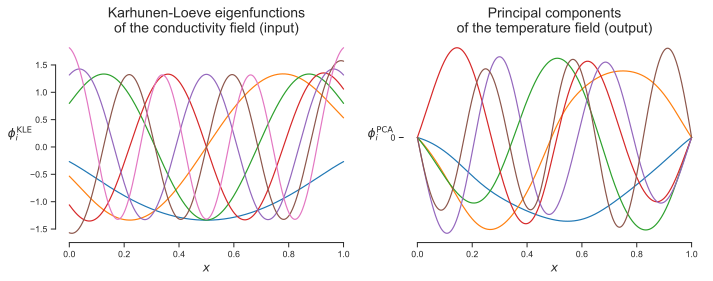

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

ax = axes[0]
ax.plot(x, kle.eval_phi(x[:, None]))
ax.set_title("Karhunen-Loeve eigenfunctions\nof the conductivity field (input)", fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel(r'$\phi^\text{KLE}_i$', rotation=0, labelpad=10, fontsize=12)
sns.despine(trim=True)

ax = axes[1]
for i in range(pca.n_components):
    ax.plot(x, pca.principal_components[i, :], label=f"Component {i}")
ax.set_title("Principal components\nof the temperature field (output)", fontsize=14)
ax.set_xlabel('$x$', fontsize=12)
ax.set_ylabel(r'$\phi^\text{PCA}_i$', rotation=0, labelpad=10, fontsize=12)
ax.set_xlabel(r"$x$")
sns.despine(trim=True)


To reiterate, every conductivity field can be approximately represented as the weighted sum 

$$
c(x) \approx \sum_{i=1}^{N_\text{KLE}} \xi_i \sqrt{\lambda_i} \phi^\text{KLE}_i(x)
$$

where the fixed functions $\{\phi^\text{KLE}_i | i=1, \dots, N_\text{KLE}\}$ are shown on the left in the figure above. 

Likewise, every temperature field can be approximately represented as the weighted sum 

$$
u(x) \approx \sum_{i=1}^{N_\text{PCA}} \eta_i \phi^\text{PCA}_i(x)
$$

where the fixed functions $\{\phi^\text{PCA}_i | i=1, \dots, N_\text{PCA}\}$ are shown on the right in the figure above.

## Surrogate for the stochastic model

We will now train a surrogate to approximate the mapping $\xi \mapsto \eta$ (i.e., the mapping from the input's KLE coefficients to the output's PCA coefficients).
This will enable fast uncertainty propagation over fields!

However, instead of directly creating one big multi-input-multi-output surrogate, we will train a separate Gaussian process surrogate for each PCA coefficient.
So, there will be a GP for the mapping $\xi \mapsto \eta_1$, another GP for $\xi \mapsto \eta_2$, and another for $\xi \mapsto \eta_3$, and so on.

Here we go:

In [11]:
def train_gp(D, measurement_noise=None, key=None, verbose=False):
    negative_mll = lambda p, d: -gpx.objectives.conjugate_mll(p, d)

    mean = gpx.mean_functions.Constant()
    kernel = gpx.kernels.RBF(lengthscale=jnp.ones(D.X.shape[1]), variance=1.0)
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=D.n
    )
    posterior = prior * likelihood

    # On GPJax version 0.9.2, static (non-trainable) parameters in the likelihood must be set after
    # the posterior object is created. When the posterior object is created, any static parameters are
    # overrided to be trainable parameters, and the `fit` function tries to optimize them.
    if measurement_noise is not None:
        posterior.likelihood.obs_stddev = gpx.parameters.Static(measurement_noise)
    
    posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        train_data=D,
        optim=optax.adam(3e-2),
        num_iters=1000,
        key=key,
        verbose=verbose
    )
    return posterior

def eval_gp(X_pred, X_train, y_train, posterior):
    D = gpx.Dataset(X_train, y_train)
    latent_dist = posterior.predict(X_pred, train_data=D)
    return latent_dist.mean(), latent_dist.stddev()

In [12]:
pca_datasets = []
posteriors = []
for i in range(pca.n_components):
    key, key_train = jrandom.split(key)
    D = gpx.Dataset(xi_train, pca.coefficients[:, i][:, None])
    posterior = train_gp(D, measurement_noise=1e-6, key=key_train, verbose=True)
    pca_datasets.append(D)
    posteriors.append(posterior)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

Great! We now have a trained GP for each PCA coefficient of the temperature field.
Let's group it all together in a single class for convenience:

In [13]:
class Surrogate(object):
    def __init__(self, models, datasets, x, pca):
        self.models = models
        self.datasets = datasets
        self.x = x
        self.pca = pca
    
    def eval_gp(self, Xi, i):
        """Returns mean and stdev of the Gaussian process corresponding to the ith PCA mode."""
        D = self.datasets[i]
        latent_dist = self.models[i].predict(Xi, train_data=D)
        return latent_dist.mean(), latent_dist.stddev()

    def __call__(self, Xi):
        coef_means = []
        coef_variances = []
        for i in range(len(self.models)):
            coef_mean, coef_std = self.eval_gp(Xi, i)
            coef_means.append(coef_mean)
            coef_variances.append(coef_std**2)
        coef_means = jnp.stack(coef_means, axis=1)
        coef_variances = jnp.stack(coef_variances, axis=1)
        mean = pca.project(coef_means)
        return mean

In [14]:
surrogate = Surrogate(posteriors, pca_datasets, x, pca)

And let's test our surrogate's accuracy.
First, let's predict the full temperature field for each test case:

In [15]:
u_test_pred = surrogate(xi_test)

And let's compare them to the true fields with a parity plot:

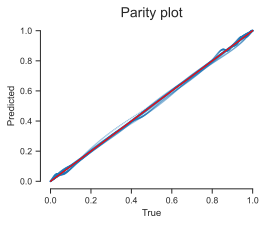

In [16]:
fig, ax = plt.subplots(figsize=(4, 3))
ax.set_title("Parity plot", fontsize=14)
ax.scatter(u_test.flatten(), u_test_pred.flatten(), 1, label="Predictions", alpha=0.3)
ax.plot([0, 1], [0, 1], 'r-', label="Ideal")
ax.set_xlabel("True")
ax.set_ylabel("Predicted")
sns.despine(trim=True);

The fit looks good.

## Uncertainty propagation

We can now use the surrogate to do uncertainty quantification tasks for very cheap!

For example, let's compute some quantiles for the distribution of $u(x)$:

In [17]:
n_samples = 1000
key, key_xi = jrandom.split(key)
xi = jrandom.normal(key_xi, shape=(n_samples, kle.num_xi))
u = surrogate(xi)

u_mean = jnp.mean(u, axis=0)
u_025, u_975 = jnp.quantile(u, jnp.array([0.025, 0.975]), axis=0)

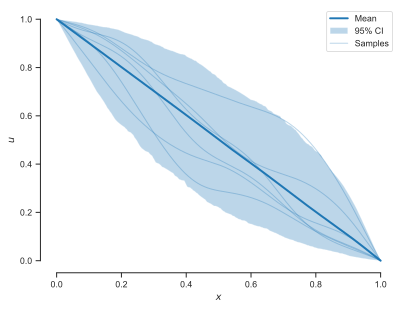

In [18]:
fig, ax = plt.subplots()
ax.plot(x, u_mean, label="Mean", lw=2, color='C0', zorder=100)
ax.fill_between(x.flatten(), u_025, u_975, alpha=0.3, label="95% CI", zorder=-100)
ax.plot(x, u[0], '-', lw=1, alpha=0.3, color='C0', label="Samples")
ax.plot(x, u[1:6].T, '-', lw=1, alpha=0.3, color='C0')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$u$")
ax.legend()
sns.despine(trim=True);

Take a moment to appreciate this.
With our newly built surrogate, we have propagated uncertainty ***through*** a partial differential equation ***from*** an infinite dimensional random field ***to another*** infinite dimensional random field.
***And*** evaluating the distribution of the entire output field only takes a fraction of a second!

Surrogates for stochastic models (like this one) can enable downstream tasks that were prohibitively expensive before.
For example, if we include some design variables in the input, we could perform design optimization under uncertainty.

## Questions

Play with the amount of training data, as well as number of KLE and PCA coefficients (controlled by the `alpha` parameters).